In [2]:
%pylab inline
import tensorflow as tf

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 22 days


Populating the interactive namespace from numpy and matplotlib


In [3]:
from fuel import config
config.data_path = ['../datasets']

In [4]:
from fuel.datasets.cifar10 import CIFAR10
from fuel.transformers import ScaleAndShift, Cast, Flatten, Mapping
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme

def vectorize_result(Y, classes):
    if Y.shape[1] != 1:
        return Y
    Y = Y.ravel()
    n = Y.shape[0]
    result = np.zeros((n, classes), dtype='float32')
    result[np.arange(n), Y] = 1.0
    return result

CIFAR10.default_transformers = (
    (ScaleAndShift, [1.0 / 255.0, 0], {'which_sources': 'features'}),
    (Cast, [np.float32], {'which_sources': 'features'}), 
    (Flatten, [], {'which_sources': 'features'}),
    (Mapping, [lambda batch: (vectorize_result(b, 10) for b in batch)], {}))
cifar_train = CIFAR10(("train",), subset=slice(None,45000))
cifar_train_stream = DataStream.default_stream(
    cifar_train,
    iteration_scheme=ShuffledScheme(cifar_train.num_examples, 100))

cifar_validation = CIFAR10(("train",), subset=slice(45000, None))

cifar_validation_stream = DataStream.default_stream(
    cifar_validation, iteration_scheme=SequentialScheme(cifar_validation.num_examples, 250))
cifar_test = CIFAR10(("test",))
cifar_test_stream = DataStream.default_stream(
    cifar_test, iteration_scheme=SequentialScheme(cifar_test.num_examples, 250))

In [5]:
images, _ = next(cifar_train_stream.get_epoch_iterator())
images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
print images.shape

(100, 32, 32, 3)


In [6]:
sess = tf.InteractiveSession()
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])

In [107]:
out = x
transform = tf.random_uniform((8,), -0.12, 0.12, dtype='float32') \
                        * tf.constant([1, 1, 32, 1, 1, 32, 0, 0], dtype='float32') \
                        + tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype='float32')
translation = tf.constant([1, 0, 16, 0, 1, 16, 0, 0], dtype='float32')
translation_back = tf.constant([1, 0, -16, 0, 1, -16, 0, 0], dtype='float32')
transform = tf.contrib.image.compose_transforms(translation, transform, translation_back)
out = tf.contrib.image.transform(out, transform)

In [108]:
transformed = sess.run(out, feed_dict={x:images})

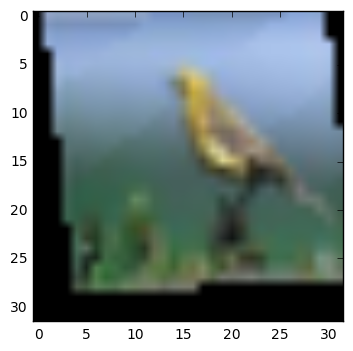

In [109]:
imshow(transformed[np.random.choice(transformed.shape[0])])

In [110]:
from skimage import transform

In [130]:
trans = transform.SimilarityTransform(rotation=0.3)
shift = transform.SimilarityTransform(translation=(16, 16))
shift_back = transform.SimilarityTransform(translation=(-16, -16))

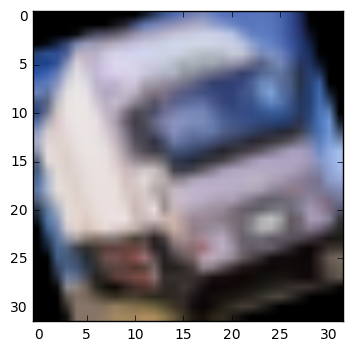

In [139]:
transformed = transform.warp(images[5], shift_back + (trans + shift), order=1)
imshow(transformed)